In [5]:
from SALib.sample import saltelli
from SALib.analyze import sobol, hdmr, delta, dgsm, pawn
from SALib.test_functions import Ishigami
import jax.numpy as jnp
import pandas as pd
import seaborn as sns
import numpy as onp
import pylab as plt
from astropy.table import Table
%matplotlib inline

In this notebook, we will use [SALib](https://salib.readthedocs.io/en/latest/index.html) Sensitivity Analysis Library in Python. Sensitivity Analysis calculate the effects of model inputs or exogenous factors on outputs of interest.

The WIkipedia definition of Sensitivity Analysis is as follows:
> the study of how the uncertainty in the output of a mathematical model or system (numerical or otherwise) can be apportioned to different sources of uncertainty in its inputs.”



Good modeling practice requires that the modeler provide an evaluation of the confidence in the model. This requires, first, a quantification of the uncertainty in any model results (uncertainty analysis); and second, an evaluation of how much each input is contributing to the output uncertainty. In models involving many input variables, sensitivity analysis is an essential ingredient of model building and quality assurance.

The choice of method of sensitivity analysis is typically dictated by a number of problem constraints or settings. Some of the most common are:
* Computational expense: requires large number of samples
* Correlated Inputs: Most common sensitivity analysis methods assume independence between model inputs
* Nonlinearity: Some approaches, such as those based on linear regression can inaccurately measure sensitivity if model response is non linear. In such cases, variance based methods are best
* Model interactions:  Interactions occur when the perturbation of two or more inputs simultaneously causes variation in the output greater than that of varying each of the inputs alone. The effect of interactions can be measured by the total-order sensitivity index.
* Multiple outputs: Virtually all sensitivity analysis methods consider a single univariate model output, yet many models output a large number of possibly spatially or time-dependent data.Note that this does not preclude the possibility of performing different sensitivity analyses for each output of interest. However, for models in which the outputs are correlated, the sensitivity measures can be hard to interpret.
* GIven data: While in many cases the practitioner has access to the model, in some instances a sensitivity analysis must be performed with "given data", i.e. where the sample points (the values of the model inputs for each run) cannot be chosen by the analyst. This may occur when a sensitivity analysis has to be performed retrospectively, perhaps using data from an optimisation or uncertainty analysis, or when data comes from a discrete source

### Methods:
There are a large number of approaches to performing a sensitivity analysis, many of which have been developed to address one or more of the constraints

#### One-at-a-time (OAT)
One of the simplest and most common approaches is that of changing one-factor-at-a-time (OAT), to see what effect this produces on the output. OAT customarily involves

1. moving one input variable, keeping others at their baseline (nominal) values, then,
2. returning the variable to its nominal value, then repeating for each of the other inputs in the same way.

Sensitivity may then be measured by monitoring changes in the output, e.g. by partial derivatives or linear regression. This appears a logical approach as any change observed in the output will unambiguously be due to the single variable changed

#### Derivative-based local methods
Local derivative-based methods involve taking the partial derivative of the output Y with respect to an input factor Xi 
Adjoint modelling and Automated Differentiation are methods in this class. Similar to OAT, local methods do not attempt to fully explore the input space, since they examine small perturbations, typically one variable at a time.

#### Regression analysis
Regression analysis, in the context of sensitivity analysis, involves fitting a linear regression to the model response and using standardized regression coefficients as direct measures of sensitivity. The regression is required to be linear with respect to the data (i.e. a hyperplane, hence with no quadratic terms, etc., as regressors) because otherwise it is difficult to interpret the standardised coefficients. This method is therefore most suitable when the model response is in fact linear; linearity can be confirmed, for instance, if the coefficient of determination is large. The advantages of regression analysis are that it is simple and has a low computational cost.

#### Variance-based methods
Variance-based methods are a class of probabilistic approaches which quantify the input and output uncertainties as probability distributions, and decompose the output variance into parts attributable to input variables and combinations of variables. The sensitivity of the output to an input variable is therefore measured by the amount of variance in the output caused by that input.These can be expressed as conditional expectations, i.e., considering a model $Y = f(X)$ for $X = {X1, X2, ... Xk}$, a measure of sensitivity of the ith variable $Xi$ is given as,

$$ \operatorname {Var} \left(E_{{\textbf {X}}_{\sim i}}\left(Y\mid X_{i}\right)\right) $$
This expression essentially measures the contribution $Xi$ alone to the uncertainty (variance) in $Y$ (averaged over variations in other variables), and is known as the first-order sensitivity index or main effect index. Importantly, it does not measure the uncertainty caused by interactions with other variables. A further measure, known as the total effect index, gives the total variance in $Y$ caused by $Xi$ and its interactions with any of the other input variables. Both quantities are typically standardised by dividing by $Var(Y)$.

Variance-based methods allow full exploration of the input space, accounting for interactions, and nonlinear responses. For these reasons they are widely used when it is feasible to calculate them. Typically this calculation involves the use of Monte Carlo methods, but since this can involve many thousands of model runs, other methods (such as emulators) can be used to reduce computational expense when necessary. Note that full variance decompositions are only meaningful when the input factors are independent from one another

#### Variogram analysis of response surfaces (VARS)
One of the major shortcomings of the previous sensitivity analysis methods is that none of them considers the spatially ordered structure of the response surface/output of the model Y=f(X) in the parameter space. By utilizing the concepts of directional variograms and covariograms, variogram analysis of response surfaces (VARS) addresses this weakness through recognizing a spatially continuous correlation structure to the values of Y, and hence also to the values of {\displaystyle {\frac {\partial Y}{\partial x_{i}}}}
The sensitivity of each input is often represented by a numeric value, called the sensitivity index. Sensitivity indices come in several forms: ${\frac {\partial Y}{\partial x_{i}}}$

Basically, the higher the variability the more heterogeneous is the response surface along a particular direction/parameter, at a specific perturbation scale. Accordingly, in the VARS framework, the values of directional variograms for a given perturbation scale can be considered as a comprehensive illustration of sensitivity information, through linking variogram analysis to both direction and perturbation scale concepts. As a result, the VARS framework accounts for the fact that sensitivity is a scale-dependent concept, and thus overcomes the scale issue of traditional sensitivity analysis methods. More importantly, VARS is able to provide relatively stable and statistically robust estimates of parameter sensitivity with much lower computational cost than other strategies (about two orders of magnitude more efficient). Noteworthy, it has been shown that there is a theoretical link between the VARS framework and the variance-based and derivative-based approaches.



* First-order indices: measures the contribution to the output variance by a single model input alone.

* Second-order indices: measures the contribution to the output variance caused by the interaction of two model inputs.

* Total-order index: measures the contribution to the output variance caused by a model input, including both its first-order effects (the input varying alone) and all higher-order interactions.

The SALib example uses the Ishigami function.

$$ f(x) = sin(x_1) + a sin^2(x_2) + b x_3^4 sin(x_1)$$

I will run through same example to demonstrate how it works

In [2]:
# Define the model inputs
problem = {
    'num_vars': 3,
    'names': ['x1', 'x2', 'x3'],
    'bounds': [[-3.14159265359, 3.14159265359],
               [-3.14159265359, 3.14159265359],
               [-3.14159265359, 3.14159265359]]
}

# Generate samples
param_values = saltelli.sample(problem, 1024)


In [3]:
param_values = saltelli.sample(problem, 1024)

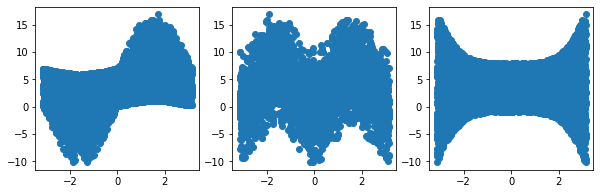

In [4]:

# Run model (example)
Y = Ishigami.evaluate(param_values)
fig,axes=plt.subplots(1,3,figsize=(10,3))
for i in range(0,3):
    axes[i].plot(param_values[:,i],Y,'o')


In [5]:
# Perform analysis
Si = sobol.analyze(problem, Y, print_to_console=True)



          ST   ST_conf
x1  0.555860  0.095718
x2  0.441898  0.041412
x3  0.244675  0.023228
          S1   S1_conf
x1  0.316832  0.066571
x2  0.443763  0.052968
x3  0.012203  0.049540
                S2   S2_conf
(x1, x2)  0.009254  0.090440
(x1, x3)  0.238172  0.102975
(x2, x3) -0.004888  0.068511


Si is a Python dict with the keys `"S1"`, `"S2"`, `"ST"`, `"S1_conf"`, `"S2_conf"`, and `"ST_conf"`. The `_conf` keys store the corresponding confidence intervals, typically with a confidence level of 95%. Use the keyword argument `print_to_console=True` to print all indices. 

In [6]:
Si['S1']

array([0.31683154, 0.44376306, 0.01220312])

Here, we see that x1 and x2 exhibit first-order sensitivities but x3 appears to have no first-order effects.

In [14]:
print(Si['ST'])


[0.55586009 0.44189807 0.24467539]


If the total-order indices are substantially larger than the first-order indices, then there is likely higher-order interactions occurring. We can look at the second-order indices to see these higher-order interactions:

In [15]:
print("x1-x2:", Si['S2'][0,1])
print("x1-x3:", Si['S2'][0,2])
print("x2-x3:", Si['S2'][1,2])

x1-x2: 0.00925429303490799
x1-x3: 0.2381721095685646
x2-x3: -0.004887704633467329


We can see there are strong interactions between x1 and x3. Some computing error will appear in the sensitivity indices. For example, we observe a negative value for the x2-x3 index. Typically, these computing errors shrink as the number of samples increases.

In [21]:
df_all=[]
nsamp=np.logspace(2,4,20).astype(int)
for s in nsamp:
    param_values = saltelli.sample(problem,s)
    Y = Ishigami.evaluate(param_values)
    Si = sobol.analyze(problem,Y)
    df,_,_=Si.to_df()
    t=df.T
    t['nsamp']=s
    t=t.set_index('nsamp',append=True)
    df_all.append(t)
df_final=pd.concat(df_all)

In [22]:
df_final

,,x1,x2,x3
,nsamp,,,
ST,100,0.584457,0.418423,0.265428
ST_conf,100,0.275830,0.133344,0.090874
ST,127,0.538997,0.461945,0.264523
ST_conf,127,0.230460,0.121505,0.086904
ST,162,0.528082,0.425446,0.239412
ST_conf,162,0.202295,0.098107,0.074731
ST,206,0.531026,0.440026,0.255356
ST_conf,206,0.181938,0.079547,0.064066
ST,263,0.550149,0.420906,0.230940


<AxesSubplot:xlabel='nsamp'>

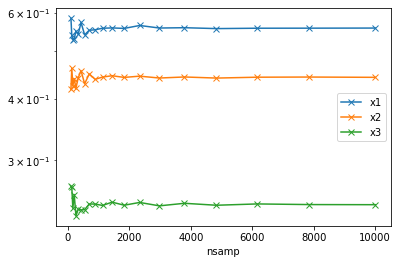

In [23]:
df_final.loc['ST',:].plot(marker='x',logy=True)

In [37]:
X = saltelli.sample(problem, 512)
Y = Ishigami.evaluate(X)
Si = hdmr.analyze(problem, X, Y,)



Term    	      Sa            Sb             S             ST         #select 
------------------------------------------------------------------------------------
x1            	  0.31 (±0.02)  0.00 (±0.01)  0.31 (±0.02)  0.55 (±0.03)    1  
x2            	  0.35 (±0.03) -0.00 (±0.01)  0.35 (±0.03)  0.35 (±0.03)    1  
x3            	  0.00 (±0.00)  0.00 (±0.00)  0.00 (±0.00)  0.25 (±0.01)    1  
x1/x2         	  0.00 (±0.00)  0.00 (±0.00)  0.00 (±0.00)                  1  
x1/x3         	  0.24 (±0.02)  0.00 (±0.01)  0.24 (±0.01)                  1  
x2/x3         	  0.00 (±0.00)  0.00 (±0.00)  0.01 (±0.00)                  1  
------------------------------------------------------------------------------------
Sum           	  0.91 (±0.00)  0.00 (±0.00)  0.90 (±0.00)


In [40]:
Si = delta.analyze(problem, X, Y, print_to_console=True)

       delta  delta_conf        S1   S1_conf
x1  0.207314    0.009840  0.313943  0.020278
x2  0.332799    0.011994  0.414569  0.021741
x3  0.163446    0.010030  0.003820  0.005296


In [43]:
Si = dgsm.analyze(problem, X,Y, print_to_console=True)

            vi      vi_std       dgsm  dgsm_conf
x1  116.188906  659.469575  33.506998  37.742447
x2         inf         NaN        inf        NaN
x3         inf         NaN        inf        NaN


In [49]:
Si = pawn.analyze(problem, X, Y, S=100, print_to_console=True)

     minimum      mean    median   maximum        CV
x1  0.165039  0.298021  0.283472  0.539893  0.281524
x2  0.201514  0.421225  0.431519  0.694385  0.263413
x3  0.090967  0.199882  0.175293  0.454688  0.387639


## Sensitivity Analysis of CIGALE and SPIRE
Parameters of the emulator are as follows:
`'log10_sfh.sfr'`,`'agn.fracAGN'`,`'universe.redshift'`,`'attenuation.Av_BC'`,`'dust.alpha'`,`'log10_sfh.tau_main'`,`'log10_sfh.age_main'`

In [6]:
alpha=onp.array([0.0625, 0.1250, 0.1875, 0.2500,0.3125, 0.3750, 0.4375, 0.5000, 0.5625, 0.6250, 0.6875, 0.7500,0.8125, 0.8750, 0.9375, 1.0000, 1.0625, 1.1250, 1.1875, 1.2500,1.3125, 1.3750, 1.4375, 1.5000, 1.5625, 1.6250, 1.6875, 1.7500, 1.8125, 1.8750, 1.9375, 2.0000, 2.0625, 2.1250, 2.1875, 2.2500,2.3125, 2.3750, 2.4375, 2.5000, 2.5625, 2.6250, 2.6875, 2.7500,2.8125, 2.8750, 2.9375, 3.0000, 3.0625, 3.1250, 3.1875, 3.2500, 3.3125, 3.3750, 3.4375, 3.5000, 3.5625, 3.6250, 3.6875, 3.7500, 3.8125, 3.8750, 3.9375, 4.0000])
alpha=alpha[::4]
#av_bc=onp.arange(0.1,4.0,0.2)
av_bc=onp.arange(0.1,4.0,0.25)
#tau=onp.arange(500,6500,200)
tau=onp.arange(500,6500,400)
z=onp.arange(0.05,6,0.4)#10.0**onp.arange(-2.5,0.77,0.1)
#sfr=10.0**onp.arange(-2,4.75,0.25)
sfr=10.0**onp.arange(-2,4.75,0.5)
agn_frac=onp.arange(0,1.0,0.075)
#agn_frac=onp.arange(0,1,0.1)


In [7]:
problem = {
    'num_vars': 6,
    'names': ['log10_sfh.sfr','agn.fracAGN','universe.redshift', 'attenuation.Av_BC','dust.alpha','log10_sfh.tau_main'],
    'bounds': [[-2, 4.75],
               [0.0, 1.0],
               [0.05,6],
              [0.1,4.0],
              [0.0625,4.0],
              [3.0,3.81]]
}

In [8]:
# Generate samples
param_values = saltelli.sample(problem, 9000)

/Users/pdh21/anaconda3/envs/xidplus/lib/python3.6/site-packages/SALib/sample/saltelli.py:94: UserWarning: 
        Convergence properties of the Sobol' sequence is only valid if
        `N` (9000) is equal to `2^n`.
        
  warnings.warn(msg)


In [9]:
param_values.shape

(126000, 6)

In [10]:
from jax import jit # for compiling functions for speedup
from jax.experimental import stax # neural network library
from jax.experimental.stax import Conv, Dense, MaxPool, Relu, Flatten, LogSoftmax, LeakyRelu # neural network layers

def CIGALE_emulator():
    output_cols=['irac_i1','omegacam_g','omegacam_i','omegacam_r','omegacam_u','omegacam_z','spire_250','spire_350','spire_500']
    net_init, net_apply = stax.serial(
        Dense(128), LeakyRelu,
        Dense(128), LeakyRelu,
        Dense(128), LeakyRelu,
        Dense(128), LeakyRelu,
        Dense(len(output_cols))
    )
    return net_init,net_apply

def load_emulatorII(filename):
    #read in net params
    x=np.load(filename, allow_pickle=True)
    net_init,net_apply=CIGALE_emulator()
    return {'net_init':net_init,'net_apply':net_apply,'params':x['arr_0'].tolist()}

In [11]:
emulator=load_emulatorII('./CIGALE_emulator_kasia_20220127.npz')


In [12]:
src_f = np.array(jnp.exp(emulator['net_apply'](emulator['params'], param_values)))



W0506 14:51:07.053375 4530445760 xla_bridge.py:234] No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [13]:
src_f.shape

(126000, 9)

In [14]:
output_cols=['irac_i1','omegacam_g','omegacam_i','omegacam_r','omegacam_u','omegacam_z','spire_250','spire_350','spire_500']


In [15]:
# Perform analysis
Si = sobol.analyze(problem, src_f[:,0])

In [16]:
df,_,_=Si.to_df()

In [17]:
df

,ST,ST_conf
log10_sfh.sfr,0.367033,0.462819
agn.fracAGN,1.001881,1.699902
universe.redshift,0.743302,1.396371
attenuation.Av_BC,0.016163,0.032280
dust.alpha,0.063083,0.068712
log10_sfh.tau_main,0.534300,0.472411


In [18]:
df_final_tmp=[]
nsamp=np.logspace(5.1,5.5,3).astype(int)
for s in nsamp:
    param_values = saltelli.sample(problem,s)
    src_f = np.array(jnp.exp(emulator['net_apply'](emulator['params'], param_values)))
    print(s)
    for i,b in enumerate(output_cols):
        Si = sobol.analyze(problem, src_f[:,i])
        df,_,_=Si.to_df()
        t=df.T.copy()
        t['band']=b
        t['nsamp']=s
        t=t.set_index('band',append=True)
        t=t.set_index('nsamp',append=True)
        
        df_final_tmp.append(t)


/Users/pdh21/anaconda3/envs/xidplus/lib/python3.6/site-packages/SALib/sample/saltelli.py:94: UserWarning: 
        Convergence properties of the Sobol' sequence is only valid if
        `N` (125892) is equal to `2^n`.
        
  warnings.warn(msg)


125892


/Users/pdh21/anaconda3/envs/xidplus/lib/python3.6/site-packages/SALib/sample/saltelli.py:94: UserWarning: 
        Convergence properties of the Sobol' sequence is only valid if
        `N` (199526) is equal to `2^n`.
        
  warnings.warn(msg)


199526


/Users/pdh21/anaconda3/envs/xidplus/lib/python3.6/site-packages/SALib/sample/saltelli.py:94: UserWarning: 
        Convergence properties of the Sobol' sequence is only valid if
        `N` (316227) is equal to `2^n`.
        
  warnings.warn(msg)


316227


In [79]:
df_final=pd.concat(df_final_tmp)



In [ ]:
df_final=pd.concat(df_final)

In [83]:
df_final=pd.concat([df_final,df_final_tmp])

/Users/pdh21/anaconda3/envs/xidplus/lib/python3.6/site-packages/ipykernel_launcher.py:3: PerformanceWarning:

indexing past lexsort depth may impact performance.

/Users/pdh21/anaconda3/envs/xidplus/lib/python3.6/site-packages/ipykernel_launcher.py:3: PerformanceWarning:

indexing past lexsort depth may impact performance.

/Users/pdh21/anaconda3/envs/xidplus/lib/python3.6/site-packages/ipykernel_launcher.py:3: PerformanceWarning:

indexing past lexsort depth may impact performance.

/Users/pdh21/anaconda3/envs/xidplus/lib/python3.6/site-packages/ipykernel_launcher.py:3: PerformanceWarning:

indexing past lexsort depth may impact performance.

/Users/pdh21/anaconda3/envs/xidplus/lib/python3.6/site-packages/ipykernel_launcher.py:3: PerformanceWarning:

indexing past lexsort depth may impact performance.

/Users/pdh21/anaconda3/envs/xidplus/lib/python3.6/site-packages/ipykernel_launcher.py:3: PerformanceWarning:

indexing past lexsort depth may impact performance.

/Users/pdh21/anaconda3

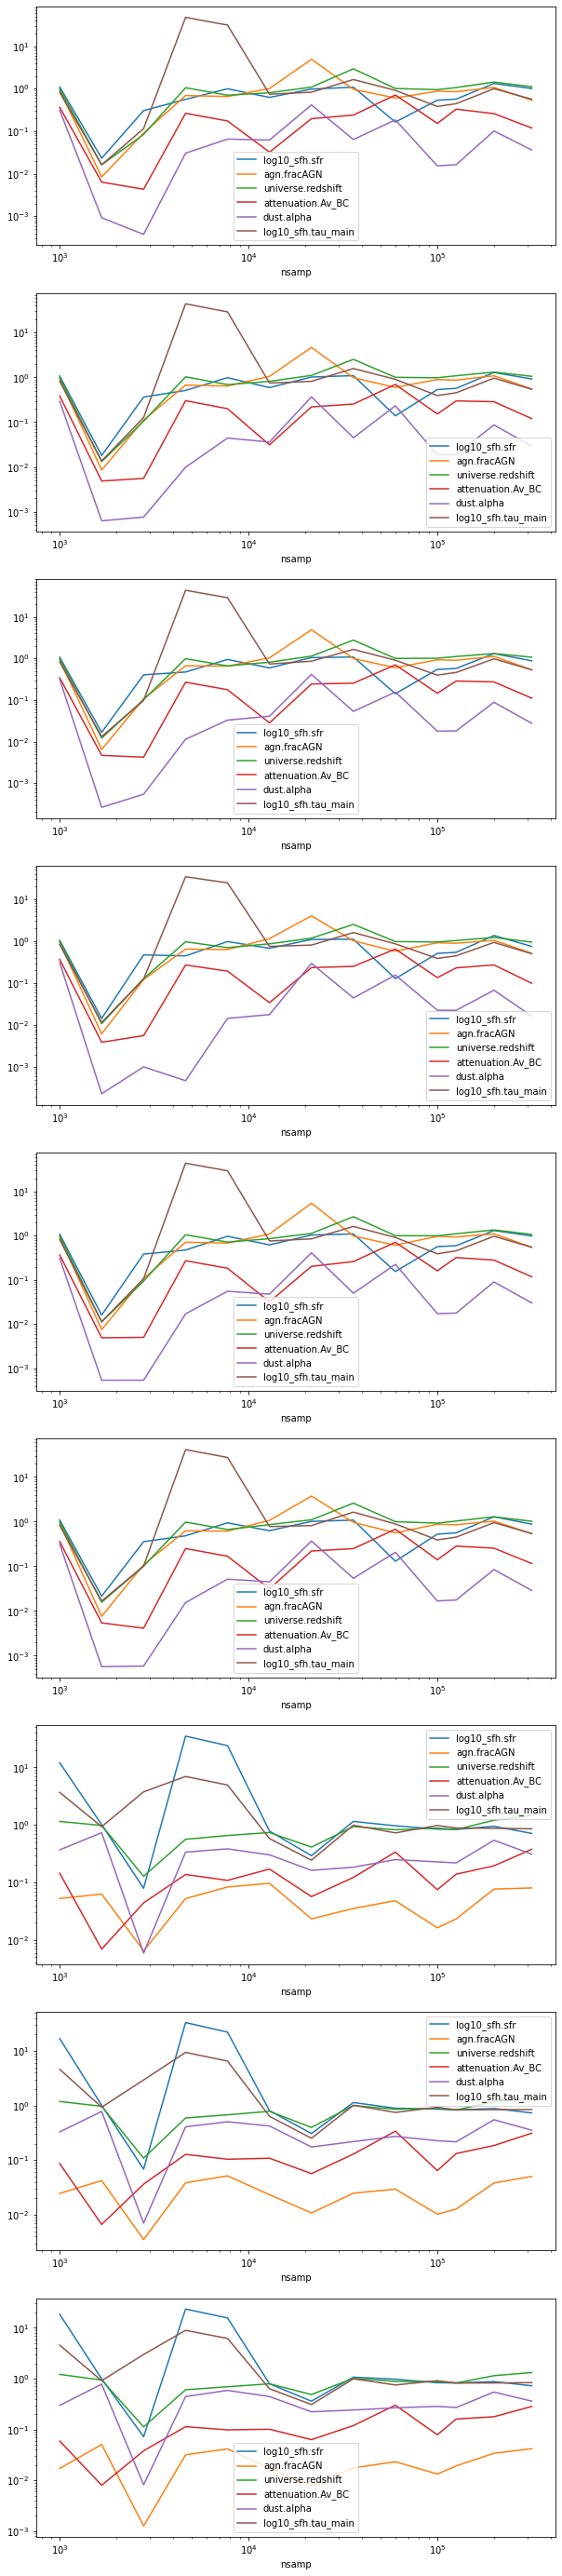

In [84]:
fig,axes=plt.subplots(len(output_cols),1,figsize=(10,50))
for i,b in enumerate(output_cols):
    df_final.loc['ST',b].plot(logy=True,logx=True,ax=axes[i])

In [85]:
import plotly.graph_objects as go
import plotly.offline as pyo


categories = problem['names']
categories = [*categories, categories[0]]
data=[]
for i,b in enumerate(output_cols):
  
    data.append(go.Scatterpolar(r=[*df_final.loc['ST',b,100000].values,df_final.loc['ST',b,100000].values[0]], theta=categories, name=b))

fig = go.Figure(
    data=data,
    layout=go.Layout(
        title=go.layout.Title(text='Photometric band Sensitivity'),
        polar={'radialaxis': {'visible': True}},
        showlegend=True
    )
)

pyo.plot(fig)

'temp-plot.html'